In [53]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

In [54]:
industry = pd.read_csv("industry.csv")
industry = industry.T
industry.index = industry.index.str.lstrip()
industry.index = industry.index.str.rstrip()
industry = industry.T

In [55]:
busi_dates = pd.Series(get_trading_dates("20230504","20230519"))

In [56]:
components = index_components('000300.XSHG')

In [57]:
hs300 = get_price_change_rate(components, start_date=20230504, end_date=20230519, expect_df=True).unstack().to_frame("price_change_rate")

In [58]:
hs300 = hs300.reset_index()

In [59]:
industry = industry.sort_values(by = "order_book_id")
industry = industry.reset_index(drop = True)
industry = industry.dropna()
industry.index = industry["order_book_id"].str.replace(" ","")
industry = industry.drop("order_book_id", axis = 0)
industry = industry.drop("order_book_id", axis = 1)
keep_rows = list(hs300["order_book_id"])
keep_rows = [*set(keep_rows)]
industry = industry.T
industry = industry[industry.columns.intersection(keep_rows)]
industry = industry.T

In [60]:
hs300 = hs300.merge(industry,on = ["order_book_id"])

In [61]:
hs300.rename(columns = {'ind_number_2021':'ind'}, inplace = True)
hs300.rename(columns = {'date':'busi_date'}, inplace = True)

In [62]:
hs300["ind"] = hs300["ind"].str.replace(" ","")
hs300["ind"] = hs300["ind"].str.lstrip("ind")
hs300["ind"] = hs300["ind"].str.zfill(2)
hs300["ind"] = "ind"+ hs300["ind"]

In [63]:
max_dates = busi_dates.to_frame("dates")
max_dates["dates"] = pd.to_datetime(max_dates["dates"])
max_dates = max_dates.groupby([max_dates.dates.dt.year, max_dates.dates.dt.month]).max().values
max_dates = pd.DataFrame(max_dates)

In [64]:
max_dates.rename(columns = {0:'dates'}, inplace = True)

In [65]:
dates = []
for values in max_dates["dates"]:
    temp = index_weights('000300.XSHG', values).rename(values)
    dates.append(temp)
weights = pd.concat(dates, axis="columns").T

In [66]:
weights = weights.reindex(busi_dates)
weights = weights.fillna(method = "bfill")
weights = weights.stack().to_frame("weights")
weights.index.names = ["busi_date","order_book_id"]

In [67]:
weights = weights.sort_index()
weights = weights.reset_index()
weights = weights.sort_values(by=["order_book_id","busi_date"])
weights = weights.reset_index(drop = True)

In [68]:
weights["busi_date"] = pd.to_datetime(weights["busi_date"])
weights = weights.iloc[:,[1,0,2]]

In [69]:
hs300 = hs300.merge(weights,on = ["order_book_id","busi_date"])

In [70]:
hs300["yield"] = hs300["price_change_rate"]*hs300["weights"]

In [71]:
hs300

,order_book_id,busi_date,price_change_rate,market,stkcode,ind,weights,yield
0,000001.XSHE,2023-05-04,0.014343,0,000001,ind17,0.00626,0.000090
1,000001.XSHE,2023-05-05,0.014140,0,000001,ind17,0.00626,0.000089
2,000001.XSHE,2023-05-08,0.031758,0,000001,ind17,0.00626,0.000199
3,000001.XSHE,2023-05-09,-0.012012,0,000001,ind17,0.00626,-0.000075
4,000001.XSHE,2023-05-10,-0.024316,0,000001,ind17,0.00626,-0.000152
...,...,...,...,...,...,...,...,...
3595,688981.XSHG,2023-05-15,0.021978,1,688981,ind20,0.00620,0.000136
3596,688981.XSHG,2023-05-16,-0.011299,1,688981,ind20,0.00620,-0.000070
3597,688981.XSHG,2023-05-17,-0.000922,1,688981,ind20,0.00620,-0.000006
3598,688981.XSHG,2023-05-18,0.016605,1,688981,ind20,0.00620,0.000103


In [72]:
ind_yields = hs300.groupby(["ind"])["yield","weights"].sum()

In [73]:
ind_yields = pd.DataFrame({"Results": ind_yields["yield"]/ind_yields["weights"]})

In [75]:
account = pd.read_csv("data.csv")
div = pd.read_csv("data20230523.csv")

In [76]:
account["busi_date"] = pd.to_datetime(account["busi_date"])
div["busi_date"] = pd.to_datetime(div["busi_date"])
div = div.drop("ttl_asset_adj", axis=1)

In [77]:
account = account.groupby(["busi_date","industry","order_book_id","hs300"])["market","stkcode","daily_profit","hs300_iweight"].sum()

In [78]:
account = account.reset_index()

In [79]:
# account["industry"] = account["industry"].str.replace(" ","")
account["industry"] = account["industry"].str.lstrip("ind")
account["industry"] = account["industry"].str.zfill(2)
account["industry"] = "ind"+ account["industry"]

In [80]:
account = account.drop("hs300", axis = 1)

In [81]:
account = account.merge(div, on="busi_date")

In [82]:
account["yield"] = account["daily_profit"]/account["prev_ttl_asset"]

In [83]:
account_ind_yields = account.groupby(["industry"])["yield","hs300_iweight"].sum()

In [84]:
account_ind_yields["total_yield"] = account_ind_yields["yield"]/account_ind_yields["hs300_iweight"]

In [85]:
results = pd.DataFrame(index = account_ind_yields.index)

In [86]:
results["Account"] = ind_yields["Results"]
results["Benchmark"] = account_ind_yields["total_yield"]

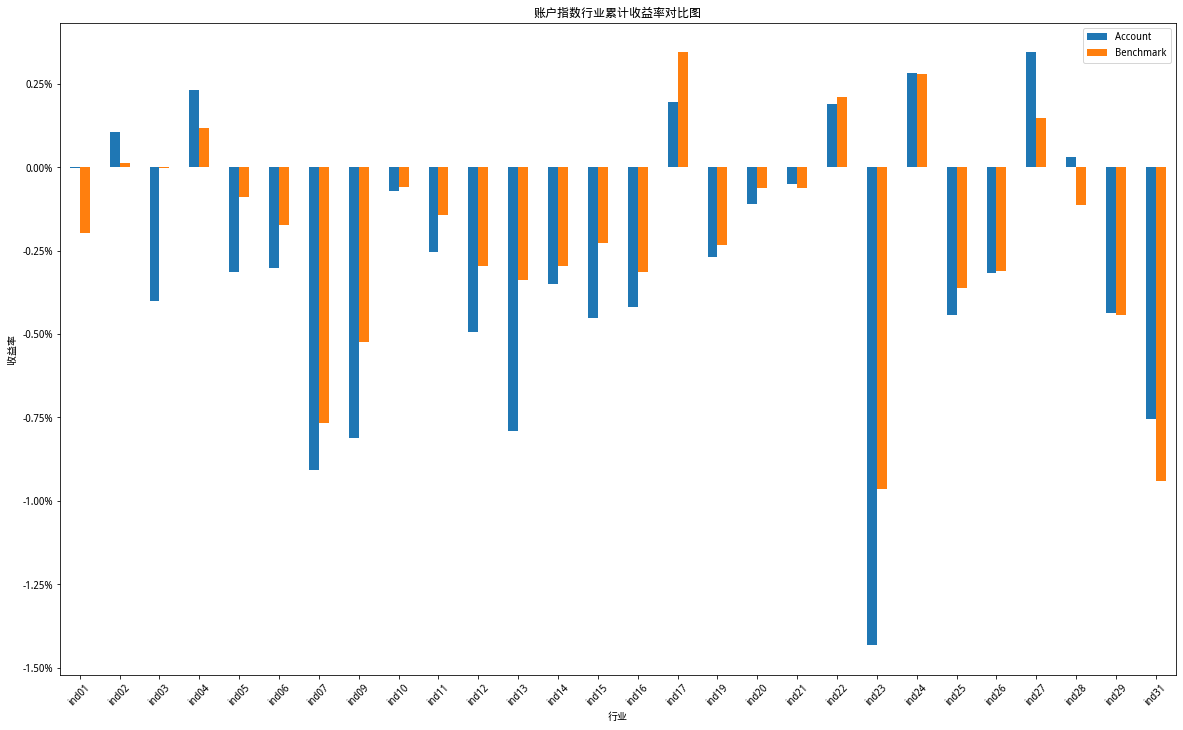

In [87]:
import matplotlib.ticker as mtick
plt.figure(figsize=(20,12))

ax=plt.subplot()
results.plot(kind='bar', ax=ax)
ax.set(title="账户指数行业累计收益率对比图", xlabel='行业', ylabel='收益率')
ax.set_xticklabels(results.index,rotation=45)
ax.legend(loc="best")
ax.yaxis.set_major_formatter(mtick.PercentFormatter(xmax=1.0))
